In [15]:
import os
import wget
import zipfile
from os.path import exists

### Chapter 5

#### Legacy Model

In [18]:
# Download if not available
bean_data_file = "./DryBeanDataset/Dry_Bean_Dataset.xlsx"
base = "https://archive.ics.uci.edu/ml/machine-learning-databases/"
dataset_number = "00602"
if not exists(bean_data_file):
    filename = "DryBeanDataset.zip"
    url = base + dataset_number + "/" + filename
    wget.download(url)
    with zipfile.ZipFile(filename, 'r') as zip_ref:
        zip_ref.extractall('./')
    os.remove(filename)

In [37]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import GaussianNB

# Read in the data from Excel file
bean_data_file = "./DryBeanDataset/Dry_Bean_Dataset.xlsx"
beans = pd.read_excel(bean_data_file)

# Labels are characters but should be integers for sklearn
le = LabelEncoder()
beans["Class"] = le.fit_transform(beans["Class"])

print(beans.shape)
len(beans['Class'].unique())
beans.head()

(13611, 17)


,Area,Perimeter,MajorAxisLength,MinorAxisLength,AspectRation,Eccentricity,ConvexArea,EquivDiameter,Extent,Solidity,roundness,Compactness,ShapeFactor1,ShapeFactor2,ShapeFactor3,ShapeFactor4,Class
0,28395,610.291,208.178117,173.888747,1.197191,0.549812,28715,190.141097,0.763923,0.988856,0.958027,0.913358,0.007332,0.003147,0.834222,0.998724,5
1,28734,638.018,200.524796,182.734419,1.097356,0.411785,29172,191.272750,0.783968,0.984986,0.887034,0.953861,0.006979,0.003564,0.909851,0.998430,5
2,29380,624.110,212.826130,175.931143,1.209713,0.562727,29690,193.410904,0.778113,0.989559,0.947849,0.908774,0.007244,0.003048,0.825871,0.999066,5
3,30008,645.884,210.557999,182.516516,1.153638,0.498616,30724,195.467062,0.782681,0.976696,0.903936,0.928329,0.007017,0.003215,0.861794,0.994199,5
4,30140,620.134,201.847882,190.279279,1.060798,0.333680,30417,195.896503,0.773098,0.990893,0.984877,0.970516,0.006697,0.003665,0.941900,0.999166,5


In [38]:
# Split data into classification target and features
y = beans["Class"]
X = beans.drop("Class", axis = 1)

# Split of training data
X_train, X_rest1, y_train, y_rest1 = train_test_split(
X, y, train_size=10000, random_state=2
)

# From the remaining data, split of test data
X_test, X_rest2, y_test, y_rest2 = train_test_split(
X_rest1, y_rest1, train_size=1000, random_state=42
)

# Split remaining into calibration and "new" data
X_calib, X_new, y_calib, y_new = train_test_split(
X_rest2, y_rest2, train_size=1000, random_state=42
)

print(X_train.shape, X_test.shape, X_calib.shape, X_new.shape)

(10000, 16) (1000, 16) (1000, 16) (1611, 16)


In [39]:
# Fit the model
model = GaussianNB().fit(X_train, y_train)

In [40]:
from sklearn.metrics import confusion_matrix

# Check accuracy
y_pred = model.predict(X_test)
print("Accuracy:", (y_pred == y_test).mean())

# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred)
print(pd.DataFrame(cm, index=le.classes_, columns=le.classes_))

Accuracy: 0.758
          BARBUNYA  BOMBAY  CALI  DERMASON  HOROZ  SEKER  SIRA
BARBUNYA        46       0    47         0      6      0     4
BOMBAY           0      33     0         0      0      0     0
CALI            20       0    81         0      3      0     0
DERMASON         0       0     0       223      0     32     9
HOROZ            0       0     4         3    104      0    22
SEKER            2       0     0        26      1    127    22
SIRA             0       0     0        10     10     21   144


#### First try: a naive approach

In [41]:
# Get the "probabilities" from the model
predictions = model.predict_proba(X_calib)

# Get for each instance the highest probability
high_prob_predictions = np.amax(predictions, axis=1)

# Select the predictions where probability over 95%
high_p_beans = np.where(high_prob_predictions >= 0.95)

# Let's count how often we hit the right label
its_a_match = (model.predict(X_calib) == y_calib)
coverage = np.mean(its_a_match.values[high_p_beans])
print(round(coverage, 3))

0.896


####  Second try: conformal classification

In [49]:
# Size of calibration data
n = len(X_calib)

# Get the probability predictions
predictions = model.predict_proba(X_calib)

# We only need the probability for the true class
prob_true_class = predictions[np.arange(n),y_calib]

# Turn into uncertainty score (larger means more uncertain)
scores = 1 - prob_true_class

In [55]:
# Setting the alpha so that we get 95% prediction sets
alpha = 0.05

# define quantile
q_level = np.ceil((n+1)*(1-alpha))/n
qhat = np.quantile(scores, q_level, method='higher')

print(round(q_level, 4), round(qhat, 4))

0.951 0.9991


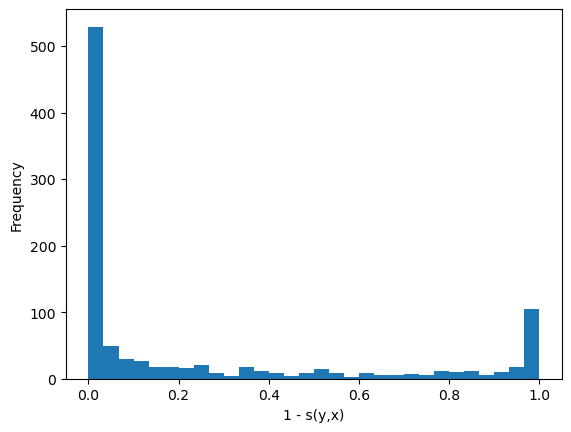

In [51]:
import matplotlib.pyplot as plt

# Get the "probabilities" from the model
predictions = model.predict_proba(X_calib)

# Get for each instance the actual probability of ground truth
prob_for_true_class = predictions[np.arange(len(y_calib)),y_calib]

# Create a histogram
plt.hist(1 - prob_for_true_class, bins=30, range=(0, 1))

# Add a title and labels
plt.xlabel("1 - s(y,x)")
plt.ylabel("Frequency")
plt.show()

In [52]:
prediction_sets = (1 - model.predict_proba(X_new) <= qhat)

In [56]:
for i in range(3):
    print(le.classes_[prediction_sets[i]])

['DERMASON']
['DERMASON']
['DERMASON' 'SEKER']


#### Getting started with MAPIE

In [60]:
from mapie.classification import MapieClassifier
cp = MapieClassifier(estimator=model, cv="prefit", method="score")
cp.fit(X_calib, y_calib)
y_pred, y_set = cp.predict(X_new, alpha=0.05)
y_set = np.squeeze(y_set)

In [61]:
for i in range(5):
    print(le.classes_[y_set[i]])

['DERMASON']
['DERMASON']
['DERMASON' 'SEKER']
['DERMASON']
['DERMASON' 'SEKER']


In [62]:
# first count number of classes per bean
set_sizes = y_set.sum(axis=1)

# use pandas to compute how often each size occurs
print(pd.Series(set_sizes).value_counts())

2    871
1    506
3    233
4      1
Name: count, dtype: int64


In [64]:
y_pred, y_set = cp.predict(X_new, alpha=0.01)

# remove the 1-dim dimension
y_set = np.squeeze(y_set)

set_sizes = y_set.sum(axis=1)
print(pd.Series(set_sizes).value_counts())

3    780
2    372
4    236
1    222
5      1
Name: count, dtype: int64


In [65]:
y_pred, y_set = cp.predict(X_new, alpha=[0.1, 0.05])

# get prediction sets for 10th observation and second alpha (0.05)
print(le.classes_[y_set[10,:,1]])

['HOROZ' 'SIRA']


In [68]:
y_pred, y_set = cp.predict(X_new, alpha=0.05)
y_set = np.squeeze(y_set)
df = pd.DataFrame()
for i in range(len(y_pred)):
    predset = le.classes_[y_set[i]]
    # Create a new dataframe with the calculated values
    temp_df = pd.DataFrame({
        "set": [predset],
        "setsize": [len(predset)]
    }, index=[i])
    # Concatenate the new dataframe with the existing one
    df = pd.concat([df, temp_df])
print(df.head())


                 set  setsize
0         [DERMASON]        1
1         [DERMASON]        1
2  [DERMASON, SEKER]        2
3         [DERMASON]        1
4  [DERMASON, SEKER]        2
